<a href="https://colab.research.google.com/github/Bulbatronik/Helbling_STARTHACK25/blob/main/notebooks/Beamforming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyroomacoustics matplotlib numpy scipy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.3-cp311-cp311-linux_x86_64.whl size=46837533 sha256=55a6ba40095cb7efa2c0de716b64e5757df70f01ab038b4dbe5686b75e35a22a
  Stored in directory: /root/.cache/pip/wheels/63/45/21/e7df2e64ca3b125fd4d6da69c8a4ee46d0ad6acc1f3de6832f
Successfully built pyroomacoustics


In [421]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import scipy.io.wavfile as wav
import scipy.signal as sps
import librosa

from IPython.display import Audio

In [442]:
fs = 8000
# Load a stored .wav file (Change the path accordingly)
wav_file1 = "Speaker27_000.wav"
#fs1, audio1 = wav.read(wav_file1)

audio1, s1 = librosa.load(wav_file1, sr=fs) # Downsample 44.1kHz to 8kHz
print(s1)

wav_file2 = "Speaker0050_000.wav"
audio2, s1 = librosa.load(wav_file2, sr=fs) # Downsample 44.1kHz to 8kHz
#print(fs1)

# Resample function
def resample_audio(audio, orig_fs, target_fs):
    return sps.resample_poly(audio, target_fs, orig_fs)

# Resample both audio files
#fs = 8000

#audio1_resampled = resample_audio(audio1, fs1, fs)
#audio2_resampled = resample_audio(audio2, fs2, fs)

8000


In [443]:
Audio(audio2, rate=fs)

In [423]:
def create_microphone_array(center, distance, num_mics):
    # Generate positions along the x-axis based on the center and distance
    x_positions = np.linspace(center[0] - (num_mics // 2) * distance, center[0] + (num_mics // 2) * distance, num_mics)

    # The y-positions are fixed (same for all microphones)
    y_positions = np.full_like(x_positions, center[1])

    # Combine the x and y positions into a 2D array
    mic_positions = np.vstack((x_positions, y_positions)).T

    return mic_positions # num_mics x 2

In [444]:
# Define room dimensions (width x height)
room_dim = [50, 50]  # m

# Create a shoebox room
room = pra.ShoeBox(room_dim, fs=fs, max_order=0, absorption=0.5)

In [445]:
# Define a linear microphone array (5 microphones along x-axis)
center = [30, 30]  # Center of the array (x, y)
distance = 0.05       # Distance between adjacent microphones
num_mics = 10         # Number of microphones

mic_positions = create_microphone_array(center, distance, num_mics) # num_mics x 2
#print(mic_positions)

mic_array = pra.MicrophoneArray(mic_positions.T, room.fs)
room.add_microphone_array(mic_array)

In [446]:
# Source positions
source_position1 = np.array([0, 10])
room.add_source(source_position1, signal=audio1)

source_position2 = np.array([50, 20])
room.add_source(source_position2, signal=audio2)

# Compute angles from the reference mic (first mic) to the sources
ref_mic = mic_positions[0]
angle1 = np.degrees(np.arctan2(source_position1[1] - ref_mic[1],
                                source_position1[0] - ref_mic[0]))
angle2 = np.degrees(np.arctan2(source_position2[1] - ref_mic[1],
                                source_position2[0] - ref_mic[0]))

# Adjust angles to be in the range [0, 360)
angle1 = angle1 % 360
angle2 = angle2 % 360


In [447]:
# Simulate the room acoustics
room.simulate()

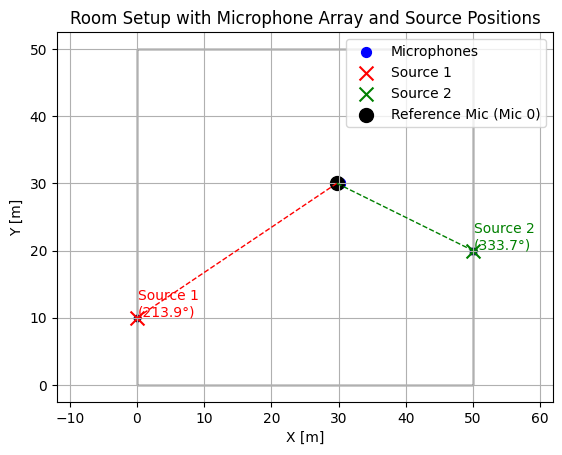

In [448]:
# Plot the setup
fig, ax = room.plot()
# Plot microphone positions
ax.scatter(mic_positions[:, 0], mic_positions[:, 1], color='b', s=50, label='Microphones')


# Plot source positions
ax.scatter(*source_position1, color='r', marker='x', s=100, label='Source 1')
ax.scatter(*source_position2, color='g', marker='x', s=100, label='Source 2')
ax.text(source_position1[0]+0.2, source_position1[1]+0.2, f'Source 1\n({angle1:.1f}°)', color='r')
ax.text(source_position2[0]+0.2, source_position2[1]+0.2, f'Source 2\n({angle2:.1f}°)', color='g')

# Draw lines from the reference microphone to the sources
ax.plot([ref_mic[0], source_position1[0]], [ref_mic[1], source_position1[1]], 'r--', linewidth=1)
ax.plot([ref_mic[0], source_position2[0]], [ref_mic[1], source_position2[1]], 'g--', linewidth=1)

# Mark the reference microphone
ax.scatter(*ref_mic, color='k', marker='o', s=100, label='Reference Mic (Mic 0)')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Room Setup with Microphone Array and Source Positions')
ax.legend()
ax.grid(True)
ax.x_lim = room_dim[0]
ax.y_lim = room_dim[1]
plt.axis('equal')
plt.show()

Target angle: 213.91171353643924


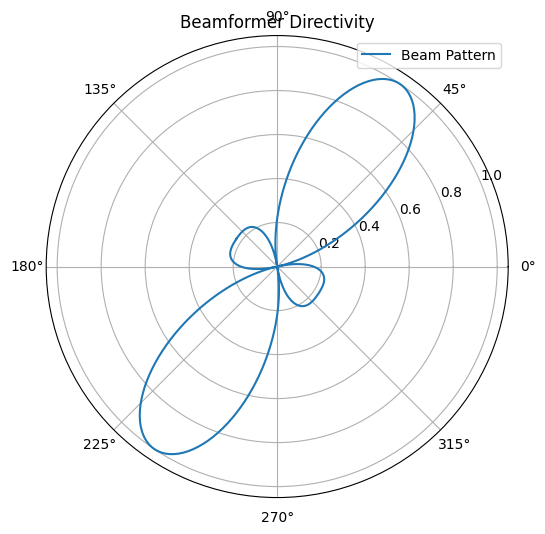

In [449]:
def compute_beampattern(mic_positions, fs, target_angle, speed_of_sound=343, num_angles=360):
    """
    Computes the beam pattern (directivity) of the Delay-and-Sum beamformer.

    Parameters:
    - mic_positions: np.array of shape (num_mics, 2), x-y coordinates of microphones.
    - fs: Sampling frequency.
    - target_angle: Steering direction in degrees.
    - speed_of_sound: Speed of sound in m/s.
    - num_angles: Number of angles to evaluate directivity.

    Returns:
    - angles: Array of angles in degrees.
    - gains: Corresponding beamformer gains.
    """
    print('Target angle:', target_angle)
    num_mics = mic_positions.shape[0]
    angles = np.linspace(0, 360, num_angles)  # Sweep over all angles
    gains = np.zeros_like(angles, dtype=np.float32)

    # Convert target angle to radians for potential use in steering
    theta_target = np.radians(target_angle)

    for i, theta in enumerate(np.radians(angles)):
        delays = np.zeros(num_mics)
        reference_mic = mic_positions[0]

        # Compute delays for this angle
        for j, mic_pos in enumerate(mic_positions):
            distance = np.dot(mic_pos - reference_mic, np.array([np.cos(theta), np.sin(theta)]))
            delays[j] = distance / speed_of_sound

        # Convert delays to phase shifts for a test frequency (1 kHz)
        frequency = 1000  # Test frequency (1 kHz)
        phase_shifts = np.exp(-1j * 2 * np.pi * frequency * delays)
        gains[i] = np.abs(np.sum(phase_shifts)) / num_mics

    # Shift angles so that 0 corresponds to the target direction
    angles_relative = (angles - target_angle) % 360

    return angles_relative, gains

# Example microphone positions (Uniform Linear Array)
mic_positions = np.array([[i * d, 0] for i in range(num_mics)])  # 5 mics in a line

# Compute directivity pattern
angles, gains = compute_beampattern(mic_positions, fs=fs, target_angle=target_angle)

# Plot directivity pattern
plt.figure(figsize=(6, 6))
plt.polar(np.radians(angles), gains, label="Beam Pattern")
plt.title("Beamformer Directivity")
plt.legend()
plt.show()

In [450]:
# Save simulated recordings from each microphone
for i, mic_signal in enumerate(room.mic_array.signals):
    wav.write(f"mic_{i}_recording.wav", fs, mic_signal.astype(np.int16))

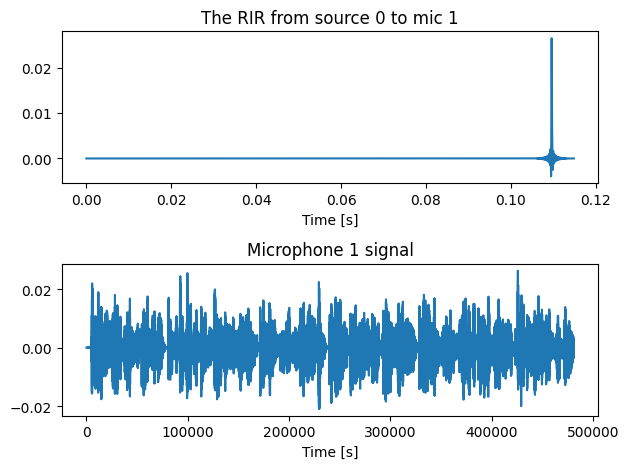

In [451]:
# Plot RIR
src = 0
mic = 1

rir = room.rir[mic][src] # mis/src
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir)) / room.fs, rir)
plt.title(f"The RIR from source {src} to mic {mic}")
plt.xlabel("Time [s]")

# plot signal at microphone
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[mic, :])
plt.title(f"Microphone {mic} signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

Audio(room.mic_array.signals[mic, :], rate=fs)

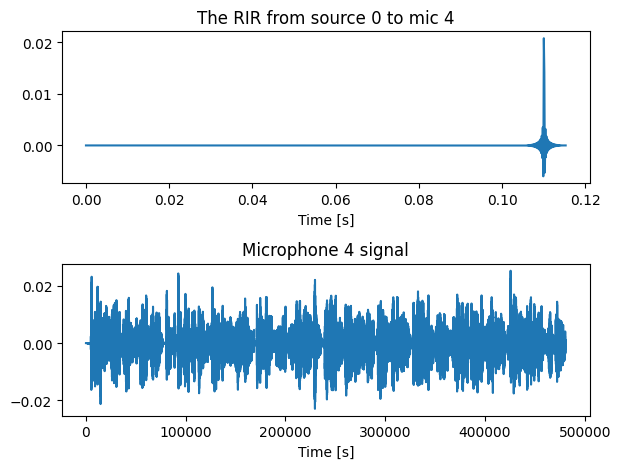

In [452]:
# Plot RIR
src = 0
mic = 4

rir = room.rir[mic][src] # mis/src
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir)) / room.fs, rir)
plt.title(f"The RIR from source {src} to mic {mic}")
plt.xlabel("Time [s]")

# plot signal at microphone
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[mic, :])
plt.title(f"Microphone {mic} signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

Audio(room.mic_array.signals[mic, :], rate=fs)

In [453]:
from scipy.signal import resample_poly, firwin, lfilter

def fractional_delay(signal, delay, fs):
    """Apply fractional delay using linear interpolation."""
    num_samples = len(signal)
    t = np.arange(num_samples) - delay  # Shift time axis
    return np.interp(t, np.arange(num_samples), signal, left=0, right=0)


def sinc_interpolation(signal, delay, num_taps=64):
    """Apply fractional delay using sinc interpolation."""
    n = np.arange(-num_taps//2, num_taps//2)
    h = np.sinc(n - delay) * np.hamming(num_taps)  # Sinc filter with Hamming window
    h /= np.sum(h)  # Normalize
    return lfilter(h, 1.0, signal)


def delay_and_sum_beamforming(mic_signals, mic_positions, fs, target_angle, speed_of_sound=343):
    """
    Apply Delay-and-Sum beamforming to enhance a source at a specific angle.

    Parameters:
    - mic_signals: np.array of shape (num_mics, num_samples), raw recordings.
    - mic_positions: np.array of shape (num_mics, 2), x-y coordinates of microphones.
    - fs: Sampling frequency.
    - target_angle: Direction of desired source in degrees.
    - speed_of_sound: Speed of sound in m/s (default 343 m/s).

    Returns:
    - beamformed_signal: np.array of shape (num_samples,), enhanced signal.
    """
    num_mics, num_samples = mic_signals.shape

    # Convert target angle to radians
    theta = np.radians(target_angle)

    # Compute delays (in seconds) for each microphone relative to the reference mic
    reference_mic = mic_positions[0]  # Use first microphone as reference
    delays = np.zeros(num_mics)
    for i, mic_pos in enumerate(mic_positions):
        # Projection of the vector from the reference mic to the current mic onto the desired direction
        distance = np.dot(mic_pos - reference_mic, np.array([np.cos(theta), np.sin(theta)]))
        delays[i] = distance / speed_of_sound
    print(f"Delays (seconds): {delays}")

    # Convert delays to sample shifts (can be fractional; here we round to integer samples)
    sample_shifts = np.rint(delays * fs).astype(int)
    print(f"Sample shifts: {sample_shifts}")

    # Shift all sample shifts so that the minimum shift becomes zero.
    # This avoids negative indexing and ensures a common overlapping segment.
    min_shift = np.min(sample_shifts)
    adjusted_shifts = sample_shifts - min_shift
    max_adjusted_shift = np.max(adjusted_shifts)

    # Determine the maximum valid length across all signals after shifting
    valid_length = num_samples - max_adjusted_shift
    if valid_length <= 0:
        raise ValueError("Not enough samples after alignment. Check the delay values or signal length.")

    # Align the signals using the adjusted shifts
    aligned_signals = np.zeros((num_mics, valid_length))
    for i in range(num_mics):
        shift = adjusted_shifts[i]
        aligned_signals[i] = mic_signals[i, shift:shift + valid_length]

    # TEST
    #aligned_signals = np.array([fractional_delay(mic_signals[i], delays[i] * fs, fs) for i in range(num_mics)])
    aligned_signals = np.array([sinc_interpolation(mic_signals[i], delays[i] * fs) for i in range(num_mics)])

    # Sum (or average) the aligned signals to perform beamforming
    beamformed_signal = np.mean(aligned_signals, axis=0)
    return beamformed_signal

Target angle: 213.91171353643924


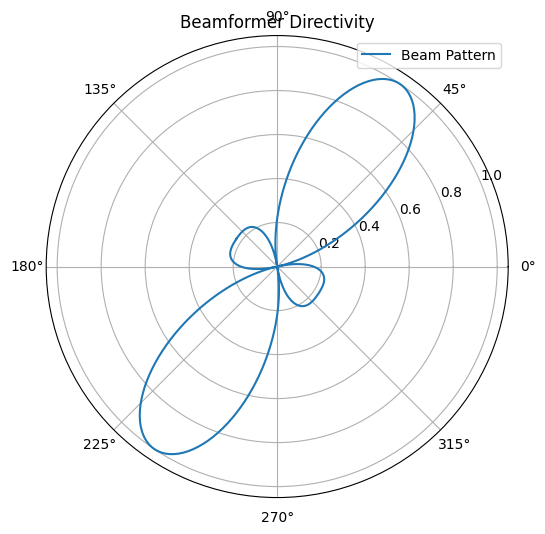

In [456]:
# Example usage
mic_signals = mic_array.signals

# Compute target angle
target_speaker = 1
target_angle = angle1 if target_speaker == 0 else angle2
print(target_angle)


# Apply beamforming
output_signal = delay_and_sum_beamforming(mic_signals, mic_positions, fs, target_angle)

# Save output
#wav.write("beamformed_output.wav", fs, output_signal.astype(np.int16))


333.7185889786798
Delays (seconds): [0.         0.0001307  0.00026141 0.00039211 0.00052282 0.00065352
 0.00078422 0.00091493 0.00104563 0.00117634]
Sample shifts: [0 1 2 3 4 5 6 7 8 9]


In [457]:
# Play the result
Audio(output_signal, rate=fs)

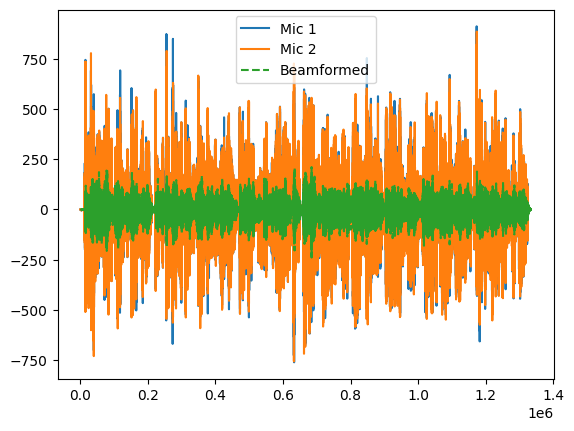

In [375]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(mic_signals[0, :], label="Mic 1")
plt.plot(mic_signals[1, :], label="Mic 2")
plt.plot(beamformed_signal, label="Beamformed", linestyle="dashed")
plt.legend()
plt.show()
